# Statistički pregled i predviđanje ishoda 1. HRL JUG
*Berislav Jakelić*

#### 1. Učitavanje potrebnih biblioteka i postavljanje URL-a

In [1]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException

import pandas as pd
import numpy as np
import csv

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

url = 'https://hrs.hr/natjecanje/?natjecanje=991'

#### 2. Web scraping stranica HRS-a i upisivanje podataka u CSV datoteke
- Tablica poretka
- Statistika najboljih strijelaca
- Rezultati odigranih utakmica
- Utakmice koje slijede

In [2]:
chrome_driver_path = 'C:\\Webdrivers\\chromedriver.exe'

chrome_service = webdriver.chrome.service.Service(chrome_driver_path)
chrome_options = webdriver.ChromeOptions()

driver = webdriver.Chrome(service=chrome_service, options=chrome_options)

driver.get(url)

WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, 'sadrzajtbs991')))

page_source = driver.page_source
soup = BeautifulSoup(page_source, 'html.parser')

target_div = soup.find('div', {'class': 'sportinfoContainer'})

if target_div:
    table = target_div.find('table')

    with open('league_table.csv', 'w', newline='', encoding='utf-8') as csvfile:
        csv_writer = csv.writer(csvfile)

        header_row = ['#', 'Team Name', 'Games Played', 'Wins', 'Draws', 'Losses', 'Goals For', 'Goals Against', 'Points']
        csv_writer.writerow(header_row)

        for idx, row in enumerate(table.find_all('tr')):
            if idx == 0:
                continue

            row.find_all('td')[0].string = ''

            data_row = [idx] + [cell.text.strip().replace(':', ',') for idx, cell in enumerate(row.find_all('td')) if idx not in [1, 9]]
            csv_writer.writerow(data_row)
    
    with open('league_table.csv', 'r', newline='', encoding='utf-8') as csvfile:
        content = csvfile.read()

    content = content.replace('"', '')
    content = content.replace(',,', ',')

    with open('league_table.csv', 'w', newline='', encoding='utf-8') as csvfile:
        csvfile.write(content)
    
    print('Scrape success!')

driver.quit()

Scrape success!


In [3]:
chrome_driver_path = 'C:\\Webdrivers\\chromedriver.exe'

chrome_service = webdriver.chrome.service.Service(chrome_driver_path)
chrome_options = webdriver.ChromeOptions()

driver = webdriver.Chrome(service=chrome_service, options=chrome_options)

driver.get(url)

WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.ID, 'tbs991_statistika_0')))
link = driver.find_element(By.XPATH, '/html/body/div[6]/div[2]/div/div[2]/div[1]/div/div[3]/div[1]/nav/ul/li[4]/a')
link.click()

page_source = driver.page_source
soup = BeautifulSoup(page_source, 'html.parser')

second_target_div = soup.find('div', {'class': 'sl-l-container'})

if second_target_div:
    second_table = soup.find('table', {'class': 'ts-w-table sl-u-margin-bottom--3'})

    with open('player_stats.csv', 'w', newline='', encoding='utf-8') as csvfile:
        csv_writer = csv.writer(csvfile)

        header_row = ['#', 'Player', 'Team', 'Goals', 'Games Played', 'Average', '7m Goals']
        csv_writer.writerow(header_row)

        for row in second_table.find_all('tr'):
            data_row = [cell.text.strip() for cell in row.find_all('td')]
            csv_writer.writerow(data_row)

    print('Scrape success!')

driver.quit()

Scrape success!


In [4]:
chrome_driver_path = 'C:\\Webdrivers\\chromedriver.exe'

chrome_service = webdriver.chrome.service.Service(chrome_driver_path)
chrome_options = webdriver.ChromeOptions()

driver = webdriver.Chrome(service=chrome_service, options=chrome_options)

driver.get(url)

WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.ID, 'tbs991_reze')))
link = driver.find_element(By.XPATH, '/html/body/div[6]/div[2]/div/div[2]/div[1]/div/div[3]/div[1]/nav/ul/li[2]/a')
link.click()

page_source = driver.page_source
soup = BeautifulSoup(page_source, 'html.parser')

rows = soup.select('.sp_sl-c-section__body .ts-w-latest-game__row')
data_list = []

for row in rows:
    home_team = row.select_one('.ts-w-latest-game__club-name').text.strip()
    away_team = row.select('.ts-w-latest-game__club-name')[1].text.strip()

    result_str = row.select_one('.ts-w-latest-game__item--score time').text.strip()
    result = [int(val) for val in result_str.split(':')]
        
    home_goals, away_goals = result
    if home_goals > away_goals:
        match_result = 'H'
    elif home_goals < away_goals:
        match_result = 'A'
    else:
        match_result = 'D'

    datetime_info = row.select_one('.ts-w-latest-game__item--score small').text.strip()

    data_list.append([home_team, home_goals, away_goals, away_team, match_result, datetime_info])

with open('results.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['Home Team', 'Home Goals', 'Away Goals', 'Away Team', 'Winner', 'Datetime'])
    csv_writer.writerows(data_list)

print('Scrape success!')

driver.quit()

Scrape success!


In [5]:
chrome_driver_path = 'C:\\Webdrivers\\chromedriver.exe'

chrome_service = webdriver.chrome.service.Service(chrome_driver_path)
chrome_options = webdriver.ChromeOptions()

driver = webdriver.Chrome(service=chrome_service, options=chrome_options)

driver.get(url)

WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.ID, 'tbs991_raspored')))
link = driver.find_element(By.XPATH, '/html/body/div[6]/div[2]/div/div[2]/div[1]/div/div[3]/div[1]/nav/ul/li[3]/a')
link.click()

page_source = driver.page_source
soup = BeautifulSoup(page_source, 'html.parser')

rows = soup.select('.sp_sl-c-section__body .ts-w-latest-game__row')
data_list = []

for row in rows:
    home_team = row.select_one('.ts-w-latest-game__club-name').text.strip()
    away_team = row.select('.ts-w-latest-game__club-name')[1].text.strip()

    data_list.append([home_team, away_team])

with open('fixtures.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['Home Team', 'Away Team'])
    csv_writer.writerows(data_list)

print('Scrape success!')

driver.quit()

Scrape success!


In [6]:
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

In [7]:
df_league_table = pd.read_csv('league_table.csv')

display('df_league_table')

,#,Team Name,Games Played,Wins,Draws,Losses,Goals For,Goals Against,Points
0,1,Zamet,19,16,2,1,585,473,34
1,2,Umag,19,14,1,4,573,485,29
2,3,Buzet,19,13,0,6,540,507,26
3,4,Zadar 1954,19,12,2,5,535,507,26
4,5,Rovinj,19,11,1,7,540,496,23
5,6,Dubovac-Gaza,19,10,1,8,490,470,21
6,7,Ardiaei,19,10,1,8,521,511,21
7,8,Hrvatski dragovoljac,19,7,1,11,406,446,15
8,9,Split,19,6,2,11,509,566,14
9,10,Kozala,19,4,2,13,478,527,10


In [8]:
df_player_stats = pd.read_csv('player_stats.csv')

display('df_player_stats')

,#,Player,Team,Goals,Games Played,Average,7m Goals
0,1.0,Marin Sinčić,Umag,138,17 (17),8.12,34
1,2.0,Nedjeljko Jurković,Rovinj,123,18 (17),6.83,47
2,3.0,Raul Valković,Buzet,114,18 (18),6.33,2
3,4.0,Ivan Čirjak,Zadar 1954,110,19 (19),5.79,38
4,5.0,Tomislav Bošnjak,Umag,108,19 (19),5.68,7
5,6.0,Tin Tomljanović,Zamet,100,15 (15),6.67,11
6,7.0,Dario Černeka,Zamet,98,19 (19),5.16,39
7,8.0,Petar Galić,Split,97,19 (19),5.11,48
8,9.0,Petar Grbac,Arena-Pula,96,19 (19),5.05,24
9,10.0,Antonio Tomaš,Kozala,95,11 (11),8.64,19


In [9]:
df_results = pd.read_csv('results.csv')

display('df_results')

,Home Team,Home Goals,Away Goals,Away Team,Winner,Datetime
0,BM 07,27,32,Hrvatski dragovoljac,A,14.4.24.
1,Umag,33,30,Rovinj,H,13.4.24.
2,Buzet,27,26,Dubovac-Gaza,H,13.4.24.
3,Split,31,34,Zadar 1954,A,13.4.24.
4,Ardiaei,31,22,Arena-Pula,H,13.4.24.
...,...,...,...,...,...,...
109,BM 07,22,32,Ardiaei,A,01.10.23.
110,Hrvatski dragovoljac,26,16,Kozala,H,30.9.23.
111,Arena-Pula,26,31,Rovinj,A,30.9.23.
112,Zadar 1954,29,28,Umag,H,30.9.23.


In [10]:
df_fixtures = pd.read_csv('fixtures.csv')

display('df_fixtures')

,Home Team,Away Team
0,Zadar 1954,BM 07
1,Hrvatski dragovoljac,Ardiaei
2,Dubovac-Gaza,Umag
3,Zamet,Split
4,Rovinj,Kozala
5,Arena-Pula,Buzet
6,Rovinj,Zamet
7,Kozala,Dubovac-Gaza
8,Umag,Arena-Pula
9,Buzet,Hrvatski dragovoljac


#### 3. Predviđanje ishoda utakmica i proračun potrebnih podataka
- Procjena snage napada i obrane
- Predviđanje ishoda budućih utakmica pojedinačno
- Predviđanje konačnog poretka
- Provjera kvalitete algoritma

In [11]:
team_name = df_league_table['Team Name']
games_played = df_league_table['Games Played']
goals_for = df_league_table['Goals For']
goals_against = df_league_table['Goals Against']

team_goals_for = pd.DataFrame({'Team Name': team_name, 'Goals For': goals_for, 'Games Played': games_played})
team_goals_against = pd.DataFrame({'Team Name': team_name, 'Goals Against': goals_against, 'Games Played': games_played})

display('team_goals_for', 'team_goals_against')

,Team Name,Goals For,Games Played
0,Zamet,585,19
1,Umag,573,19
2,Buzet,540,19
3,Zadar 1954,535,19
4,Rovinj,540,19
5,Dubovac-Gaza,490,19
6,Ardiaei,521,19
7,Hrvatski dragovoljac,406,19
8,Split,509,19
9,Kozala,478,19


In [12]:
average_goals_for = goals_for / games_played
average_goals_against = goals_against / games_played

team_average_goals_for = pd.DataFrame({'Team Name': team_name, 'Average Goals For': average_goals_for})
team_average_goals_against = pd.DataFrame({'Team Name': team_name, 'Average Goals Against': average_goals_against})

display('team_average_goals_for', 'team_average_goals_against')

,Team Name,Average Goals For
0,Zamet,30.789474
1,Umag,30.157895
2,Buzet,28.421053
3,Zadar 1954,28.157895
4,Rovinj,28.421053
5,Dubovac-Gaza,25.789474
6,Ardiaei,27.421053
7,Hrvatski dragovoljac,21.368421
8,Split,26.789474
9,Kozala,25.157895


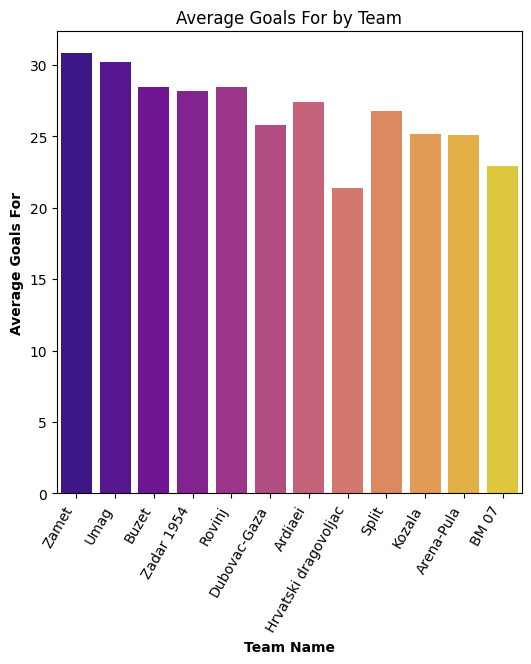

In [13]:
plt.figure(figsize=(6, 6))
sns.barplot(x='Team Name', y='Average Goals For', data=team_average_goals_for, hue='Team Name', palette='plasma', dodge=False)
plt.title('Average Goals For by Team')
plt.xlabel('Team Name', fontweight='bold')
plt.ylabel('Average Goals For', fontweight='bold')
plt.xticks(rotation=60, ha='right')
plt.show()

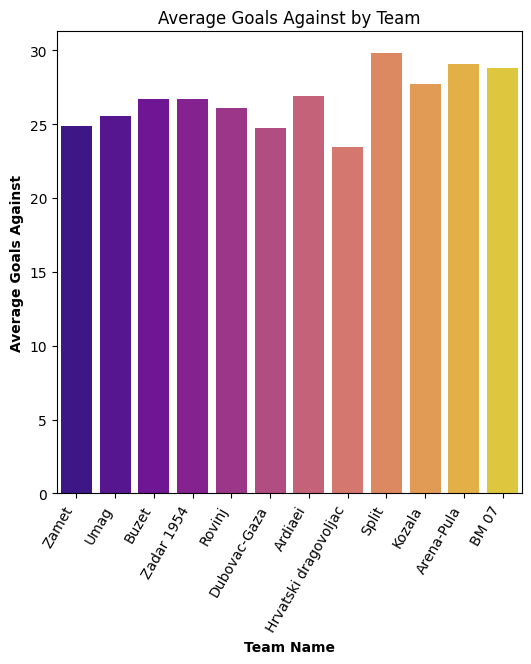

In [14]:
plt.figure(figsize=(6, 6))
sns.barplot(x='Team Name', y='Average Goals Against', data=team_average_goals_against, hue='Team Name', palette='plasma', dodge=False)
plt.title('Average Goals Against by Team')
plt.xlabel('Team Name', fontweight='bold')
plt.ylabel('Average Goals Against', fontweight='bold')
plt.xticks(rotation=60, ha='right')
plt.show()

In [15]:
bin_edges_attack = [0, 22, 23, 24, 25, 26, 27, 28, 29, 30, np.inf]
bin_labels_attack = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
bin_edges_defence = [0, 22, 23, 24, 25, 26, 27, 28, 29, 30, np.inf]
bin_labels_defence = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

team_average_goals_for['Attack Power'] = pd.cut(team_average_goals_for['Average Goals For'], bins=bin_edges_attack, labels=bin_labels_attack, include_lowest=True)
team_average_goals_against['Defence Power'] = pd.cut(team_average_goals_against['Average Goals Against'], bins=bin_edges_defence, labels=bin_labels_defence, include_lowest=True)

display('team_average_goals_for', 'team_average_goals_against')

,Team Name,Average Goals For,Attack Power
0,Zamet,30.789474,10
1,Umag,30.157895,10
2,Buzet,28.421053,8
3,Zadar 1954,28.157895,8
4,Rovinj,28.421053,8
5,Dubovac-Gaza,25.789474,5
6,Ardiaei,27.421053,7
7,Hrvatski dragovoljac,21.368421,1
8,Split,26.789474,6
9,Kozala,25.157895,5


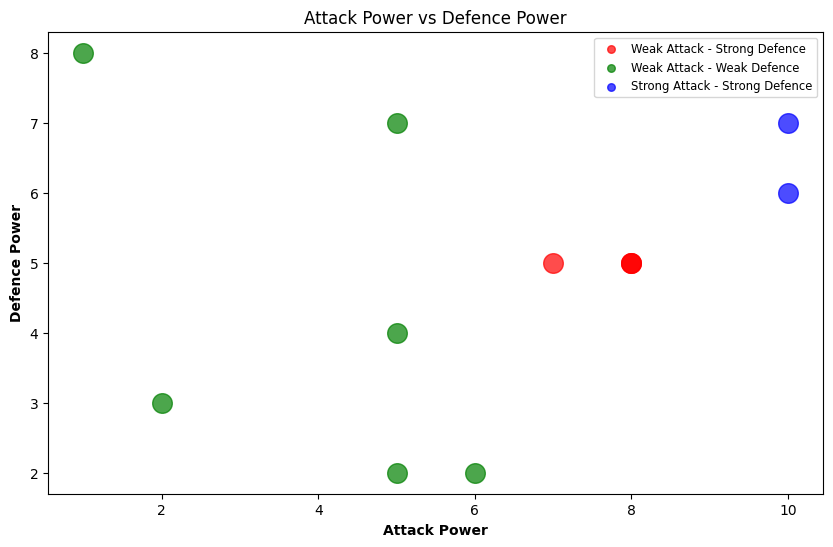

In [16]:
import mplcursors

team_power = pd.merge(team_average_goals_for, team_average_goals_against, on='Team Name')

features = team_power[['Attack Power', 'Defence Power']]

kmeans = KMeans(n_clusters=3, random_state=42)
team_power['Cluster'] = kmeans.fit_predict(features)

cluster_names = ['Weak Attack - Strong Defence', 'Weak Attack - Weak Defence', 'Strong Attack - Strong Defence']
cluster_colors = ['red', 'green', 'blue']

plt.figure(figsize=(10, 6))
for i, cluster_name in enumerate(cluster_names):
    cluster_data = team_power[team_power['Cluster'] == i]
    scatter = plt.scatter(cluster_data['Attack Power'], cluster_data['Defence Power'], label=cluster_name, color=cluster_colors[i], alpha=0.7, s=200)

    # Add annotations for hover labels
    mplcursors.cursor(scatter, hover=True).connect("add", lambda sel: sel.annotation.set_text(team_power.iloc[sel.target.index]['Team Name']))

plt.title('Attack Power vs Defence Power')
plt.xlabel('Attack Power', fontweight='bold')
plt.ylabel('Defence Power', fontweight='bold')
legend = plt.legend(fontsize='small')
for handle in legend.legend_handles:
    handle._sizes = [30]
plt.show()


In [17]:
team_average_goals_for['Attack Power'] = team_average_goals_for['Attack Power'].astype(float)
team_average_goals_against['Defence Power'] = team_average_goals_against['Defence Power'].astype(float)

team_overall_power = team_average_goals_for['Attack Power'] + team_average_goals_against['Defence Power']
team_overall_power = pd.DataFrame({'Team Name': team_name, 'Overall Power': team_overall_power})
display('team_overall_power')

,Team Name,Overall Power
0,Zamet,17.0
1,Umag,16.0
2,Buzet,13.0
3,Zadar 1954,13.0
4,Rovinj,13.0
5,Dubovac-Gaza,12.0
6,Ardiaei,12.0
7,Hrvatski dragovoljac,9.0
8,Split,8.0
9,Kozala,9.0


In [18]:
threshold = 0
goal_difference = df_results.groupby('Home Team')['Home Goals'].sum() - df_results.groupby('Home Team')['Away Goals'].sum()

home_bonus = pd.DataFrame({'Team Name': goal_difference.index, 'Bonus': (goal_difference > threshold).astype(float)}).reset_index(drop=True)

home_bonus.loc[home_bonus['Bonus'] == 0, 'Bonus'] = 0.5

display('home_bonus')

,Team Name,Bonus
0,Ardiaei,1.0
1,Arena-Pula,0.5
2,BM 07,0.5
3,Buzet,1.0
4,Dubovac-Gaza,1.0
5,Hrvatski dragovoljac,1.0
6,Kozala,0.5
7,Rovinj,1.0
8,Split,0.5
9,Umag,1.0


In [19]:
fixture_predictions = pd.DataFrame(columns=['Home Team', 'Away Team', 'Home Team Power', 'Away Team Power'])

merged_df = pd.merge(df_fixtures, team_overall_power, left_on='Home Team', right_on='Team Name', how='left').rename(columns={'Overall Power': 'Home Team Power'})
merged_df = pd.merge(merged_df, team_overall_power, left_on='Away Team', right_on='Team Name', how='left').rename(columns={'Overall Power': 'Away Team Power'})

merged_df = pd.merge(merged_df, home_bonus, left_on='Home Team', right_on='Team Name', how='left').rename(columns={'Bonus': 'Home Bonus'})

merged_df[['Home Team Power', 'Away Team Power', 'Home Bonus']] = merged_df[['Home Team Power', 'Away Team Power', 'Home Bonus']].fillna(0)

merged_df['Home Team Power'] += merged_df['Home Bonus']

fixture_predictions['Home Team'] = merged_df['Home Team']
fixture_predictions['Away Team'] = merged_df['Away Team']
fixture_predictions['Home Team Power'] = merged_df['Home Team Power']
fixture_predictions['Away Team Power'] = merged_df['Away Team Power']

fixture_predictions['Predicted Outcome'] = 'D'
fixture_predictions.loc[merged_df['Home Team Power'] > merged_df['Away Team Power'], 'Predicted Outcome'] = 'H'
fixture_predictions.loc[merged_df['Home Team Power'] < merged_df['Away Team Power'], 'Predicted Outcome'] = 'A'

fixture_predictions.to_csv('fixture_predictions.csv', index=False)
display('fixture_predictions')


,Home Team,Away Team,Home Team Power,Away Team Power,Predicted Outcome
0,Zadar 1954,BM 07,14.0,5.0,H
1,Hrvatski dragovoljac,Ardiaei,10.0,12.0,A
2,Dubovac-Gaza,Umag,13.0,16.0,A
3,Zamet,Split,18.0,8.0,H
4,Rovinj,Kozala,14.0,9.0,H
5,Arena-Pula,Buzet,7.5,13.0,A
6,Rovinj,Zamet,14.0,17.0,A
7,Kozala,Dubovac-Gaza,9.5,12.0,A
8,Umag,Arena-Pula,17.0,7.0,H
9,Buzet,Hrvatski dragovoljac,14.0,9.0,H


In [20]:
team_names = pd.unique(fixture_predictions[['Home Team', 'Away Team']].values.ravel('K'))
points_prediction = pd.DataFrame({'Team Name': team_names, 'Predicted Points': 0})

for _, row in fixture_predictions.iterrows():
    home_team = row['Home Team']
    away_team = row['Away Team']
    predicted_outcome = row['Predicted Outcome']

    if predicted_outcome == 'D':
        points_prediction.loc[points_prediction['Team Name'].isin([home_team, away_team]), 'Predicted Points'] += 1
    elif predicted_outcome == 'H':
        points_prediction.loc[points_prediction['Team Name'] == home_team, 'Predicted Points'] += 2
    elif predicted_outcome == 'A':
        points_prediction.loc[points_prediction['Team Name'] == away_team, 'Predicted Points'] += 2

display('points_prediction')

,Team Name,Predicted Points
0,Zadar 1954,5
1,Hrvatski dragovoljac,0
2,Dubovac-Gaza,3
3,Zamet,6
4,Rovinj,3
5,Arena-Pula,0
6,Kozala,2
7,Umag,6
8,Buzet,4
9,Ardiaei,5


In [21]:
league_table_prediction = pd.merge(df_league_table, points_prediction, on='Team Name', how='left')

league_table_prediction[['Predicted Points']] = league_table_prediction[['Predicted Points']].fillna(0)

league_table_prediction['Total Points'] = league_table_prediction['Points'] + league_table_prediction['Predicted Points']

columns_to_drop = ['Games Played', 'Wins', 'Draws', 'Losses', 'Goals For', 'Goals Against', 'Points', 'Predicted Points']
league_table_prediction = league_table_prediction.drop(columns=columns_to_drop)

league_table_prediction = league_table_prediction.sort_values(by='Total Points', ascending=False)

display('league_table_prediction')

,#,Team Name,Total Points
0,1,Zamet,40
1,2,Umag,35
3,4,Zadar 1954,31
2,3,Buzet,30
4,5,Rovinj,26
6,7,Ardiaei,26
5,6,Dubovac-Gaza,24
8,9,Split,16
7,8,Hrvatski dragovoljac,15
9,10,Kozala,12


In [22]:
prev_fixtures = df_results[['Home Team', 'Away Team']].copy()

results_test = pd.DataFrame(columns=['Home Team', 'Away Team', 'Predicted Winner'])

merged_df = pd.merge(prev_fixtures, team_overall_power, left_on='Home Team', right_on='Team Name', how='left').rename(columns={'Overall Power': 'Home Team Power'})
merged_df = pd.merge(merged_df, team_overall_power, left_on='Away Team', right_on='Team Name', how='left').rename(columns={'Overall Power': 'Away Team Power'})

merged_df = pd.merge(merged_df, home_bonus, left_on='Home Team', right_on='Team Name', how='left').rename(columns={'Bonus': 'Home Bonus'})

merged_df[['Home Team Power', 'Away Team Power', 'Home Bonus']] = merged_df[['Home Team Power', 'Away Team Power', 'Home Bonus']].fillna(0)

merged_df['Home Team Power'] += merged_df['Home Bonus']

results_test['Home Team'] = merged_df['Home Team']
results_test['Away Team'] = merged_df['Away Team']
results_test['Home Team Power'] = merged_df['Home Team Power']
results_test['Away Team Power'] = merged_df['Away Team Power']

results_test['Predicted Winner'] = 'D'
results_test.loc[merged_df['Home Team Power'] > merged_df['Away Team Power'], 'Predicted Winner'] = 'H'
results_test.loc[merged_df['Home Team Power'] < merged_df['Away Team Power'], 'Predicted Winner'] = 'A'

results_test = pd.merge(results_test, df_results[['Home Team', 'Away Team', 'Winner']], on=['Home Team', 'Away Team'], how='left', suffixes=('_predicted', '_actual'))

df_comparison = results_test[['Home Team', 'Away Team', 'Winner', 'Predicted Winner']].copy()
df_comparison['Correct'] = (df_comparison['Winner'] == df_comparison['Predicted Winner']).astype(int)

correct_predictions_ratio = df_comparison['Correct'].sum() / len(df_comparison)

df_comparison.to_csv('prev_fixtures_comparison.csv', index=False)

display('df_comparison')

,Home Team,Away Team,Winner,Predicted Winner,Correct
0,BM 07,Hrvatski dragovoljac,A,A,1
1,Umag,Rovinj,H,H,1
2,Buzet,Dubovac-Gaza,H,H,1
3,Split,Zadar 1954,A,A,1
4,Ardiaei,Arena-Pula,H,H,1
...,...,...,...,...,...
109,BM 07,Ardiaei,A,A,1
110,Hrvatski dragovoljac,Kozala,H,H,1
111,Arena-Pula,Rovinj,A,A,1
112,Zadar 1954,Umag,H,A,0


In [23]:
print("Correct Predictions Percentage:", round(correct_predictions_ratio * 100, 2), "%")

Correct Predictions Percentage: 79.82 %


#### 4. Pregled statistike najboljih strijelaca
- Utjecaj izvođenja sedmeraca
- Utjecaj pojedinca na momčad

In [24]:
player_name = df_player_stats['Player']
goals_scored = df_player_stats['Goals']
penalties_scored = df_player_stats['7m Goals']
goals_without_penalties = goals_scored - penalties_scored

player_goals_and_penalties = pd.DataFrame({'Player': player_name, 'Goals': goals_scored, '7m Goals': penalties_scored, 'Goals from Open Play': goals_without_penalties})
display('player_goals_and_penalties')

,Player,Goals,7m Goals,Goals from Open Play
0,Marin Sinčić,138,34,104
1,Nedjeljko Jurković,123,47,76
2,Raul Valković,114,2,112
3,Ivan Čirjak,110,38,72
4,Tomislav Bošnjak,108,7,101
5,Tin Tomljanović,100,11,89
6,Dario Černeka,98,39,59
7,Petar Galić,97,48,49
8,Petar Grbac,96,24,72
9,Antonio Tomaš,95,19,76


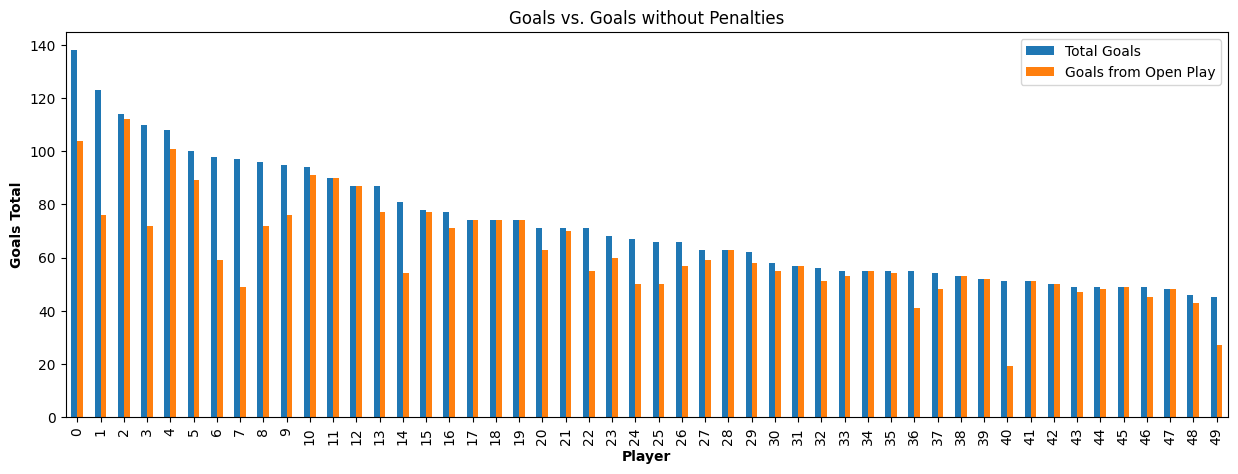

In [25]:
fig, ax = plt.subplots(figsize=(15, 5))

player_goals_and_penalties[['Goals', 'Goals from Open Play']].plot(kind='bar', ax=ax)
plt.title('Goals vs. Goals without Penalties')
plt.xlabel('Player', fontweight='bold')
plt.ylabel('Goals Total', fontweight='bold')
plt.legend(['Total Goals', 'Goals from Open Play'])
plt.show()

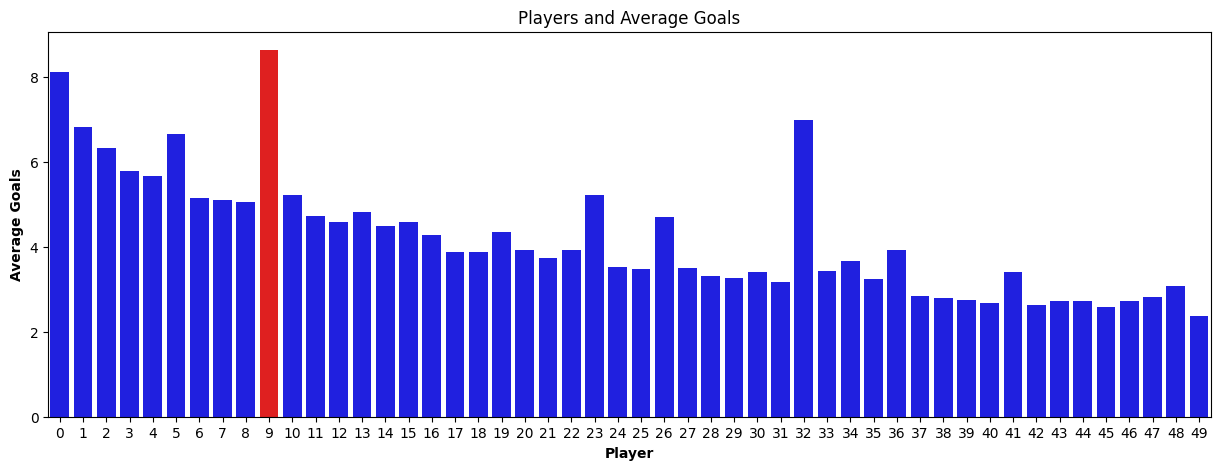

In [26]:
threshold = 8.5
above_threshold_color = 'red'

colors = ['red' if x > threshold else 'blue' for x in df_player_stats['Average']]

plt.figure(figsize=(15, 5))
sns.barplot(x=df_player_stats.index, y='Average', data=df_player_stats, hue='Player', palette=colors, legend=0)
plt.title('Players and Average Goals')
plt.xlabel('Player', fontweight='bold')
plt.ylabel('Average Goals', fontweight='bold')
plt.show()

In [27]:
mask_home = df_results['Home Team'] == 'Kozala'
mask_away = df_results['Away Team'] == 'Kozala'

df_tomas_kozala_home = df_results[mask_home].copy()
df_tomas_kozala_home['Opponent'] = df_tomas_kozala_home['Away Team'] + ' (H)'
df_tomas_kozala_home['Goals For'] = df_tomas_kozala_home['Home Goals']
df_tomas_kozala_home['Win or Draw'] = (df_tomas_kozala_home['Winner'].isin(['H', 'D'])).astype(int)

df_tomas_kozala_away = df_results[mask_away].copy()
df_tomas_kozala_away['Opponent'] = df_tomas_kozala_away['Home Team'] + ' (A)'
df_tomas_kozala_away['Goals For'] = df_tomas_kozala_away['Away Goals']
df_tomas_kozala_away['Win or Draw'] = (df_tomas_kozala_away['Winner'].isin(['A', 'D'])).astype(int)

df_tomas_kozala = pd.concat([df_tomas_kozala_home, df_tomas_kozala_away], ignore_index=True)

columns_to_drop = ['Home Team', 'Home Goals', 'Away Goals', 'Away Team', 'Winner', 'Datetime']
df_tomas_kozala = df_tomas_kozala.drop(columns=columns_to_drop)

display('df_tomas_kozala')

,Opponent,Goals For,Win or Draw
0,Zamet (H),26,0
1,Umag (H),28,0
2,Ardiaei (H),30,1
3,Split (H),28,1
4,Hrvatski dragovoljac (H),23,1
5,Arena-Pula (H),34,1
6,Rovinj (H),27,1
7,Buzet (H),23,0
8,BM 07 (H),25,0
9,Zadar 1954 (H),23,0


In [28]:
import time

chrome_driver_path = 'C:\\Webdrivers\\chromedriver.exe'

chrome_service = webdriver.chrome.service.Service(chrome_driver_path)
chrome_options = webdriver.ChromeOptions()

driver = webdriver.Chrome(service=chrome_service, options=chrome_options)

driver.get(url)

WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.ID, 'tbs991_reze')))
link = driver.find_element(By.XPATH, '/html/body/div[6]/div[2]/div/div[2]/div[1]/div/div[3]/div[1]/nav/ul/li[2]/a')
link.click()

link_elements = driver.find_elements(By.XPATH, '//a[@class="ts-w-latest-game  ts-w-latest-game--over"]')

df_temp_list = []

time.sleep(3)

for link_element in link_elements:
    team_left = link_element.find_element(By.CLASS_NAME, 'ts-w-latest-game__item--team-left').find_element(By.CLASS_NAME, 'ts-w-latest-game__club-name').text
    team_right = link_element.find_element(By.CLASS_NAME, 'ts-w-latest-game__item--team-right').find_element(By.CLASS_NAME, 'ts-w-latest-game__club-name').text
    
    if 'Kozala' in [team_left, team_right]:
        link_element.click()
        
        try:
            player_name_elements = WebDriverWait(driver, 10).until(
                EC.presence_of_all_elements_located((By.CLASS_NAME, 'ts-w-livescore-team__player-name'))
            )

            for player_name_element in player_name_elements:
                if 'Antonio Tomaš' in player_name_element.text:
                    opponent = [team_left, team_right]
                    if (team_left == 'Kozala'):
                        opponent.remove('Kozala')
                        opponent_name = opponent[0] + ' (H)'
                    else:
                        opponent.remove('Kozala')
                        opponent_name = opponent[0] + ' (A)'

                    next_td_element = player_name_element.find_element(By.XPATH, 'following-sibling::td')
                    goals_scored = float(next_td_element.text)

                    df_temp = pd.DataFrame({'Opponent': [opponent_name], 'Played In': [1], 'Goals Scored': [goals_scored]})
                    df_temp_list.append(df_temp)
                
        except TimeoutException:
            print(0)
        
        driver.back()

driver.quit()

if df_temp_list:
    df_temp = pd.concat(df_temp_list, ignore_index=True)

df_tomas_kozala = pd.merge(df_tomas_kozala, df_temp, on=['Opponent'], how='left')

df_tomas_kozala['Played In'].fillna(0, inplace=True)
df_tomas_kozala['Goals Scored'].fillna(0, inplace=True)

df_tomas_kozala['Played In'] = df_tomas_kozala['Played In'].astype(np.float64)
df_tomas_kozala['Goals Scored'] = df_tomas_kozala['Goals Scored'].astype(int)

display('df_tomas_kozala')


StaleElementReferenceException: Message: stale element reference: stale element not found
  (Session info: chrome=123.0.6312.123); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#stale-element-reference-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7A0E74C82+3505170]
	(No symbol) [0x00007FF7A0AA0852]
	(No symbol) [0x00007FF7A0954145]
	(No symbol) [0x00007FF7A09590C1]
	(No symbol) [0x00007FF7A095B54B]
	(No symbol) [0x00007FF7A095B610]
	(No symbol) [0x00007FF7A099974C]
	(No symbol) [0x00007FF7A0999C1C]
	(No symbol) [0x00007FF7A098F31C]
	(No symbol) [0x00007FF7A09BBECF]
	(No symbol) [0x00007FF7A098F27A]
	(No symbol) [0x00007FF7A09BC0A0]
	(No symbol) [0x00007FF7A09D83B2]
	(No symbol) [0x00007FF7A09BBC33]
	(No symbol) [0x00007FF7A098D618]
	(No symbol) [0x00007FF7A098E6B1]
	GetHandleVerifier [0x00007FF7A0EA67DD+3708781]
	GetHandleVerifier [0x00007FF7A0EFFC5D+4074477]
	GetHandleVerifier [0x00007FF7A0EF7DDF+4042095]
	GetHandleVerifier [0x00007FF7A0BCA136+708806]
	(No symbol) [0x00007FF7A0AACB0F]
	(No symbol) [0x00007FF7A0AA7D14]
	(No symbol) [0x00007FF7A0AA7E6C]
	(No symbol) [0x00007FF7A0A979A4]
	BaseThreadInitThunk [0x00007FFC0EB6257D+29]
	RtlUserThreadStart [0x00007FFC0FB2AA48+40]


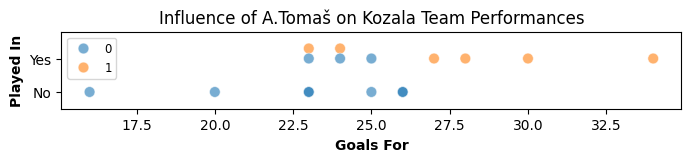

In [ ]:
jitter_amount = 0.3

overlapping_rows = df_tomas_kozala.duplicated(subset=['Goals For', 'Played In'], keep=False) & ~(df_tomas_kozala.duplicated(subset=['Goals For', 'Played In', 'Win or Draw'], keep=False)) & (df_tomas_kozala['Win or Draw'] == 1)

df_tomas_kozala_jittered = df_tomas_kozala.copy()
df_tomas_kozala_jittered.loc[overlapping_rows, 'Played In'] = (df_tomas_kozala_jittered.loc[overlapping_rows, 'Played In'] + jitter_amount).astype(np.float64)

plt.figure(figsize=(8, 1))
sns.scatterplot(x='Goals For', y='Played In', hue='Win or Draw', data=df_tomas_kozala_jittered, s=60, alpha=0.6)
plt.ylim(df_tomas_kozala_jittered['Played In'].min() - 0.5, df_tomas_kozala_jittered['Played In'].max() + 0.5)
plt.title('Influence of A.Tomaš on Kozala Team Performances')
plt.xlabel('Goals For', fontweight='bold')
plt.ylabel('Played In', fontweight='bold')
plt.yticks([0, 1], ['No', 'Yes'])
legend = plt.legend(fontsize='small', loc='upper left')
for handle in legend.legend_handles:
    handle._sizes = [10]
plt.show()

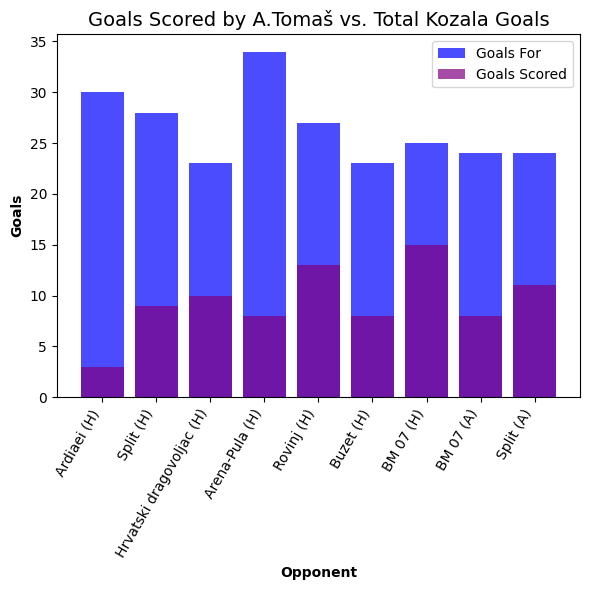

In [ ]:
df_filtered = df_tomas_kozala[df_tomas_kozala['Played In'] == 1]

plt.figure(figsize=(6, 6))
plt.bar(df_filtered['Opponent'], df_filtered['Goals For'], label='Goals For', color='blue', alpha=0.7)
plt.bar(df_filtered['Opponent'], df_filtered['Goals Scored'], label='Goals Scored', color='purple', alpha=0.7)
plt.title('Goals Scored by A.Tomaš vs. Total Kozala Goals', fontsize=14)
plt.xlabel('Opponent', fontweight='bold')
plt.ylabel('Goals', fontweight='bold')
plt.xticks(rotation=60, ha='right')
plt.legend()
plt.tight_layout()
plt.show()